In [1]:
! pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! python -m pip install git+https://github.com/adam-coogan/jaxinterp2d.git@master

  Cloning https://github.com/adam-coogan/jaxinterp2d.git (to revision master) to /private/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/pip-req-build-oyvgda93
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for jaxinterp2d: filename=jaxinterp2d-0.0.1-py3-none-any.whl size=4073 sha256=710912b873066d20b05b17c6672d3d1eca89fef46b2998bf1d52b9854520bf18
  Stored in directory: /private/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/pip-ephem-wheel-cache-aub4kw5p/wheels/92/82/d7/d3e8d4aa082c9562e0eae6ab146d013074715c37c1e592c474
Successfully built jaxinterp2d


In [8]:
import jax.numpy as jnp
import jax
from jax import random
import numpy as np

## Strong lensing simulator

In [10]:
asctorad = np.pi / 648000.0
radtoasc = 648000.0 / np.pi

In [11]:
class MassProfileSIE:
    def __init__(self, x_0, y_0, r_E, q):
        """
        Singular isothermal ellipsoid (SIE) mass profile class
        :param x_0: x-coordinate of center of deflector, in same units as r_E
        :param y_0: y-coordinate of center of deflector, in same units as r_E
        :param r_E: Einstein radius of deflector
        :param q: Axis-ratio of deflector
        """
        self.x_0 = x_0
        self.y_0 = y_0
        self.r_E = r_E
        self.q = q

    def deflection(self, x, y):
        """
        Calculate deflection vectors, from astro-ph/0102341
        TODO: deal with origin singularity
        :param x: x-coordinate at which deflection computed, in same units as r_E
        :param y: y-coordinate at which deflection computed, in same units as r_E
        :return: Deflections at positions specified by x, y
        """
        # Go into shifted coordinates
        x_p = x - self.x_0
        y_p = y - self.y_0
        
        # Compute deflection field
        psi = jnp.sqrt((self.q * x_p) ** 2 + y_p ** 2)

        x_d = jnp.where(self.q == 1., self.r_E * x_p / psi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctan(jnp.sqrt(1 - self.q ** 2) * x_p / psi))
        y_d = jnp.where(self.q == 1., self.r_E * y_p / psi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctanh(jnp.sqrt(1 - self.q ** 2) * y_p / psi))

        # Return deflection field
        return x_d, y_d


In [26]:
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15
from astropy.convolution import convolve, Gaussian2DKernel

import jax.numpy as jnp

from jaxinterp2d import CartesianGrid


class LensingSim:
    def __init__(self, lenses_list=[{}], sources_list=[{}], global_dict={}, observation_dict={}):
        """
        Class for simulation of strong lensing images
        """

        self.lenses_list = lenses_list
        self.sources_list = sources_list

        self.global_dict = global_dict
        self.observation_dict = observation_dict

        self.set_up_global()
        self.set_up_observation()

    def set_up_global(self):
        """ Set some global variables so don't need to recompute each time
        """
        self.z_s = self.global_dict["z_s"]
        self.z_l = self.global_dict["z_l"]

        self.D_s = Planck15.angular_diameter_distance(z=self.z_s).value
        self.D_l = Planck15.angular_diameter_distance(z=self.z_l).value

    def set_up_observation(self):
        """ Set up observational grid and parameters
        """
        
        # Coordinate limits (in arcsecs)
        self.theta_x_lims = self.observation_dict["theta_x_lims"]
        self.theta_y_lims = self.observation_dict["theta_y_lims"]

        # Size of grid
        self.n_x = self.observation_dict["n_x"]
        self.n_y = self.observation_dict["n_y"]

        # Exposure and background noise level
        self.exposure = self.observation_dict["exposure"]

        # x/y-coordinates of grid and pixel area in arcsec ** 2

        self.theta_x, self.theta_y = jnp.meshgrid(
            jnp.linspace(self.theta_x_lims[0], self.theta_x_lims[1], self.n_x),
            jnp.linspace(self.theta_y_lims[0], self.theta_y_lims[1], self.n_y)
        )

        self.x, self.y = self.D_l * self.theta_x * asctorad, self.D_l * self.theta_y * asctorad

        self.x_lims, self.y_lims = self.D_l * asctorad * jnp.array(self.theta_x_lims), self.D_l * asctorad * jnp.array(
            self.theta_y_lims)

        self.pix_area = ((self.theta_x_lims[1] - self.theta_x_lims[0]) / self.n_x) * (
                    (self.theta_y_lims[1] - self.theta_y_lims[0]) / self.n_y)

    def lensed_image(self):
        """ Get strongly lensed image
        """

        # Get lensing potential gradients

        x_d, y_d = jnp.zeros((self.n_x, self.n_y)), jnp.zeros((self.n_x, self.n_y))

        for lens_dict in self.lenses_list:
            if lens_dict["profile"] == "SIE":
                _x_d, _y_d = MassProfileSIE(
                    x_0=lens_dict["theta_x_0"] * self.D_l * asctorad,
                    y_0=lens_dict["theta_y_0"] * self.D_l * asctorad,
                    r_E=lens_dict["theta_E"] * self.D_l * asctorad,
                    q=lens_dict["q"],
                ).deflection(self.x, self.y)
            else:
                raise Exception("Unknown lens profile specification!")

            x_d += _x_d
            y_d += _y_d
            
        # Evaluate source image on deflected lens plane to get lensed image

        f_lens = jnp.zeros((self.n_x, self.n_y))

        for source_dict in self.sources_list:
            
            src_ary = source_dict["src_ary"]
            f_lens += CartesianGrid(limits=[self.x_lims, self.y_lims], values=src_ary)(self.x - x_d, self.y - y_d)

        i_tot = f_lens * self.exposure * self.pix_area  # Total lensed image

        return i_tot

    @staticmethod
    def _mag_to_flux(mag, mag_zp):
        """
        Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
        """
        return 10 ** (-0.4 * (mag - mag_zp))

In [57]:
n_xy = 28
coordinate_limits = 1.

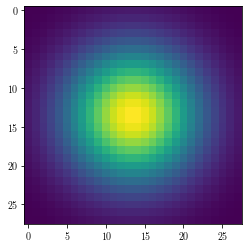

In [141]:
from scipy.stats import multivariate_normal

delta_pix = 2 * coordinate_limits / n_xy
sigma_psf = 0.5

x_kern = np.linspace(-6, 6, n_xy)
x, y = np.meshgrid(x_kern, x_kern)
kernel = multivariate_normal(mean=np.zeros(2), cov=np.ones(2) * sigma_psf / delta_pix).pdf(np.dstack((x, y)))
kernel /= np.sum(kernel)

plt.imshow(kernel)

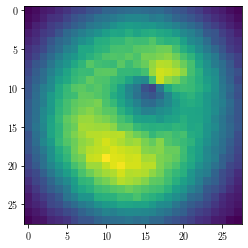

In [81]:
lens_dict = {"profile":"SIE", "theta_x_0":0.2, "theta_y_0":-0.3, "theta_E":0.5, "q":0.7}
observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}
global_dict = {"z_s":1.0, "z_l":0.5}

lensing_sim = LensingSim(lenses_list=[lens_dict], sources_list=[{"src_ary":kernel}], global_dict=global_dict, observation_dict=observation_dict)

lensed_image = np.random.poisson(lensing_sim.lensed_image())

plt.imshow(lensed_image)

## Lensing parameter inference

In [82]:
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist

from tqdm.notebook import tqdm

In [83]:
@jax.jit
def lensing_simulator(theta_x_0, theta_y_0, theta_E, q):
    lens_dict = {"profile":"SIE", "theta_x_0":theta_x_0, "theta_y_0":theta_y_0, "theta_E":theta_E, "q":q}
    observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}
    global_dict = {"z_s":1.0, "z_l":0.5}

    lensing_sim = LensingSim(lenses_list=[lens_dict], sources_list=[{"src_ary":kernel}], global_dict=global_dict, observation_dict=observation_dict)

    lensed_image = lensing_sim.lensed_image()
    
    return lensed_image

In [120]:
def model(image):
    """ Model definition in Pyro
    """
    
    # Stochastic nodes
    theta_x_0 = numpyro.sample("theta_x_0", dist.Uniform(0., 0.5))
    theta_y_0 = numpyro.sample("theta_y_0", dist.Normal(0., 0.5))
    theta_E = numpyro.sample("theta_E", dist.Uniform(0.1, 2.0))
    q = numpyro.sample("q", dist.Uniform(0.5, 0.99))
    
    # Deterministic node
    mu_pred = numpyro.deterministic("mu_pred", lensing_simulator(theta_x_0, theta_y_0, theta_E, q))
    
    # N different independent observations
    with numpyro.plate_stack('observed_data', image.shape, rightmost_dim=-1):
        return numpyro.sample("obs", dist.Poisson(mu_pred), obs=image)

In [132]:
# Define a guide
guide = autoguide.AutoMultivariateNormal(model)

In [137]:
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 10000, lensed_image)
params = svi_results.params

100%|██████████| 10000/10000 [00:11<00:00, 848.93it/s, init loss: 31164.7109, avg. loss [9501-10000]: 3914.4707]


In [138]:
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(10000,))
samples_svi = np.array([samples_svi['theta_x_0'], samples_svi['theta_y_0'], samples_svi['theta_E'], samples_svi['q'] ]).T

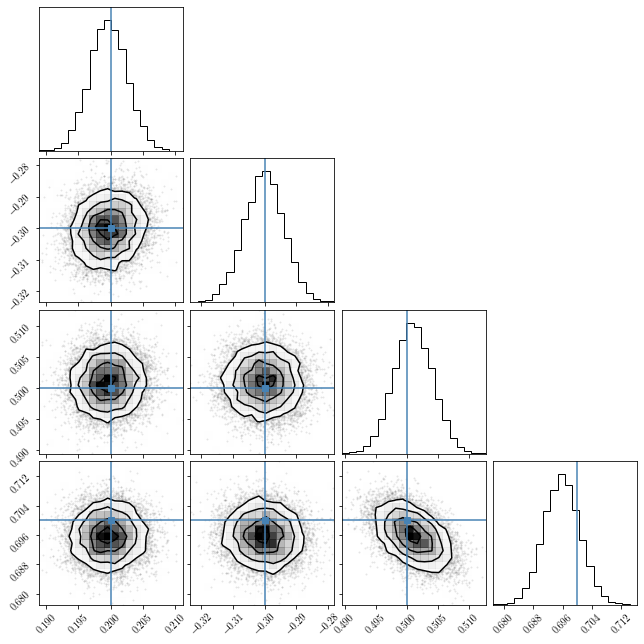

In [139]:
import corner

corner.corner(samples_svi, truths=[0.2, -0.3, 0.5, 0.7]);

## Generative model

In [ ]:
from flax import linen as nn
from flax.training import train_state

import optax
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
latents = 128
num_epochs = 50
batch_size = 128
learning_rate = 1e-3

In [5]:
class Encoder(nn.Module):
    c_hid : int = 32
    latents : int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x) 
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.c_hid, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
        mean_x = nn.Dense(self.latents)(x)
        logvar_x = nn.Dense(self.latents)(x)
        return mean_x, logvar_x

class Decoder(nn.Module):
    c_out : int = 1
    c_hid : int = 32

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=7 * 7 *self.c_hid)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], 7, 7, -1)
        x = nn.ConvTranspose(features=2 * self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3, 3), strides=(1, 1))(x)
        return x

class VAE(nn.Module):
    latents: int = 20

    def setup(self):
        self.encoder = Encoder(latents=self.latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def generate(self, z):
        return nn.sigmoid(self.decoder(z))


def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))


def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

def model():
    return VAE(latents=latents)


In [6]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = model().apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        comparison = jnp.concatenate([images[:8].reshape(-1, 28, 28, 1),
                                      recon_images[:8].reshape(-1, 28, 28, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({'params': params})

def prepare_image(x):
    x = tf.cast(x['image'], tf.float32)
    return x

In [7]:
# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], 'GPU')

rng = random.PRNGKey(0)
rng, key = random.split(rng)

ds_builder = tfds.builder('binarized_mnist')
ds_builder.download_and_prepare()
train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.cache()
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.batch(batch_size)
train_ds = iter(tfds.as_numpy(train_ds))

test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
test_ds = test_ds.map(prepare_image).batch(10000)
test_ds = np.array(list(test_ds)[0])
test_ds = jax.device_put(test_ds)

In [8]:
init_data = jnp.ones((batch_size, 28, 28, 1), jnp.float32)

state = train_state.TrainState.create(
    apply_fn=model().apply,
    params=model().init(key, init_data, rng)['params'],
    tx=optax.adam(learning_rate),
)

rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (64, latents))

steps_per_epoch = 50000 // batch_size

for epoch in range(num_epochs):
    for _ in range(steps_per_epoch):
        batch = next(train_ds)
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
      epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

eval epoch: 2, loss: 119.8892, BCE: 86.7981, KLD: 33.0911
eval epoch: 3, loss: 112.1238, BCE: 80.4740, KLD: 31.6499
eval epoch: 4, loss: 107.9409, BCE: 76.4232, KLD: 31.5177
eval epoch: 5, loss: 105.1747, BCE: 73.3762, KLD: 31.7985
eval epoch: 6, loss: 103.6083, BCE: 72.7858, KLD: 30.8225
eval epoch: 7, loss: 102.5286, BCE: 72.1471, KLD: 30.3815
eval epoch: 8, loss: 101.3283, BCE: 70.4642, KLD: 30.8641
eval epoch: 9, loss: 100.7159, BCE: 69.9050, KLD: 30.8109
eval epoch: 10, loss: 100.3642, BCE: 68.6687, KLD: 31.6955
eval epoch: 11, loss: 99.6911, BCE: 68.3035, KLD: 31.3876
eval epoch: 12, loss: 99.1876, BCE: 67.0684, KLD: 32.1191
eval epoch: 13, loss: 98.8886, BCE: 67.7235, KLD: 31.1650
eval epoch: 14, loss: 98.6167, BCE: 67.8765, KLD: 30.7402
eval epoch: 15, loss: 98.3571, BCE: 67.0892, KLD: 31.2679
eval epoch: 16, loss: 98.1799, BCE: 67.5425, KLD: 30.6374
eval epoch: 17, loss: 97.8683, BCE: 67.0859, KLD: 30.7824
eval epoch: 18, loss: 97.7834, BCE: 65.5452, KLD: 32.2382
eval epoch: 1

In [9]:
rng = jax.random.PRNGKey(1)
rng, z_key, eval_rng = random.split(rng, 3)
z = jax.random.normal(z_key, (16, latents))

In [10]:
metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

In [1]:
import matplotlib.pyplot as plt

for i in range(16):
    plt.imshow(sample[i, :, :, 0])
    plt.show()